# Small Benchmark
This notebook runs a small benchmark for  ParquetDB, PyArrow, and SQLite across comparable read/write/query operations. This was first conducted by Christopher Körber and adapated by Logan Lang for this notebook

## Benchmark Details
- **Data Generation:** Generates 1,000,000 rows × 100 columns of integers (0–1,000,000). Integers are chosen as a basic primitive type—byte size is the main factor, so these results represent a **lower bound** on performance; more complex or larger types will incur higher cost.
- **ParquetDB Normalization (defaults):** row-group size 50,000–100,000 rows, max rows per file 10,000,000. Tuning these can shift performance between inserts, reads, and updates.

## System Specifications
- **Operating System:** Windows 10  
- **Processor:** AMD Ryzen 7 3700X 8‑Core @ 3.6 MHz (8 cores, 16 logical processors)  
- **Memory:** 128 GB DDR4‑3600 MHz (4×32 GB DIMMs) 
- **Storage**: SATA HDD 2TB (Model: ST2000DM008-2FR102)

## Setup

In [1]:
!pip install parquetdb

In [2]:
import os
import time
import shutil

import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq
import pyarrow.dataset as ds

from parquetdb import config
from parquetdb.utils import general_utils

bench_dir = os.path.join(config.data_dir, 'benchmarks')
sqlite_dir = os.path.join(bench_dir, 'sqlite')
pa_dir = os.path.join(bench_dir, 'pyarrow')
pq_dir = os.path.join(bench_dir, 'parquetdb')

for d in (sqlite_dir, pa_dir, pq_dir):
    os.makedirs(d, exist_ok=True)

[INFO] 2025-04-28 13:20:18 - parquetdb.utils.config[37][load_config] - Config file: C:\Users\lllang\AppData\Local\parquetdb\parquetdb\config.yml
[INFO] 2025-04-28 13:20:18 - parquetdb.utils.config[41][load_config] - Setting data_dir to Z:\data\parquetdb\data


## Test Data

In [6]:
orders=np.arange(7)
data_dict = {}

col_prefix = "col"
for order in orders:
    data_dict[order] = general_utils.generate_pylist_data(n_rows=10**order, min_value=0, max_value=1_000_000, prefix=col_prefix) 
    
parquetdb_filters = [pa.compute.field(f"{col_prefix}1") > 100, pa.compute.field(f"{col_prefix}97") < 1000]
pyarrow_filter = (pa.compute.field(f"{col_prefix}1") > 100) & (pa.compute.field(f"{col_prefix}97") < 1000)
sql_query = f"{col_prefix}1 > 100 and {col_prefix}97 < 1000"

CREATE_TIMES={
    "parquetdb":{"mean":[], "std":[]},
    "pyarrow":{"mean":[], "std":[]},
    "sqlite":{"mean":[], "std":[]}
}

READ_TIMES={
    "parquetdb":{"mean":[], "std":[]},
    "pyarrow":{"mean":[], "std":[]},
    "sqlite":{"mean":[], "std":[]}
}

QUERY_TIMES={
    "parquetdb":{"mean":[], "std":[]},
    "pyarrow":{"mean":[], "std":[]},
    "sqlite":{"mean":[], "std":[]}
}


## Using PyArrow Directly

In [7]:
pyarrow_dir = os.path.join(pa_dir, "pyarrow")

def pyarrow_benchmark_experiment(data):
    
    if os.path.exists(pyarrow_dir):
        shutil.rmtree(pyarrow_dir)
    os.makedirs(pyarrow_dir, exist_ok=True)
    
    
    create_time = time.time()
    start = 0 
    table = pa.Table.from_pylist(data).add_column(0, 'id', [range(start, start + len(data))])
    temp_file_path=os.path.join(pyarrow_dir, "0.parquet")
    pq.write_table(table, temp_file_path)
    create_time=time.time() - create_time
    del table
    
    read_time = time.time()
    dataset = ds.dataset(pyarrow_dir, format="parquet")
    table=dataset.to_table(filter=None)
    read_time = time.time() - read_time
    del table
    del dataset

    query_time = time.time()
    dataset = ds.dataset(pyarrow_dir, format="parquet")
    table=dataset.to_table(filter=pyarrow_filter)
    query_time = time.time() - query_time
    
    return create_time, read_time, query_time
    
    
experiment_dict = { key: {} for key in range(5)}
for run_name, benchmark_dict in experiment_dict.items():
    tmp_dict={}
          
    create_times = []
    read_times = []
    query_times=[]
    for order, data in data_dict.items():
        create_time, read_time, query_time = pyarrow_benchmark_experiment(data)
        create_times.append(create_time)
        read_times.append(read_time)
        query_times.append(query_time)
        
    tmp_dict = {
        "create_times": create_times,
        "read_times": read_times,
        "query_times": query_times
    }
    benchmark_dict[run_name] = tmp_dict

mean_create_times=[]
mean_read_times=[]
mean_query_times=[]

std_create_times=[]
std_read_times=[]
std_query_times=[]
for order, data in data_dict.items():
    tmp_create_times=[]
    tmp_read_times=[]
    tmp_query_times=[]
    for run_name, benchmark_dict in experiment_dict.items():
        tmp_create_times.append(benchmark_dict[run_name]['create_times'][order])
        tmp_read_times.append(benchmark_dict[run_name]['read_times'][order])
        tmp_query_times.append(benchmark_dict[run_name]['query_times'][order])
    mean_create_times.append(float(np.mean(tmp_create_times)))
    mean_read_times.append(float(np.mean(tmp_read_times)))
    mean_query_times.append(float(np.mean(tmp_query_times)))
    std_create_times.append(float(np.std(tmp_create_times)))
    std_read_times.append(float(np.std(tmp_read_times)))
    std_query_times.append(float(np.std(tmp_query_times)))


CREATE_TIMES['pyarrow']["mean"] = mean_create_times
CREATE_TIMES['pyarrow']["std"] = std_create_times

READ_TIMES['pyarrow']["mean"] = mean_read_times
READ_TIMES['pyarrow']["std"] = std_read_times

QUERY_TIMES['pyarrow']["mean"] = mean_query_times
QUERY_TIMES['pyarrow']["std"] = std_query_times


In [8]:
print("Create Times:")
print(CREATE_TIMES['pyarrow']["mean"])
print("Read Times:")
print(READ_TIMES['pyarrow']["mean"])
print("Query Times:")
print(QUERY_TIMES['pyarrow']["mean"])

Create Times:
[0.007800912857055664, 0.009195232391357422, 0.01038656234741211, 0.037519407272338864, 0.3952972888946533, 5.838534593582153, 55.53361873626709]
Read Times:
[0.012827444076538085, 0.012448263168334962, 0.011999797821044923, 0.011917877197265624, 0.014612627029418946, 0.047410774230957034, 0.3932796478271484]
Query Times:
[0.004358243942260742, 0.004599761962890625, 0.004617071151733399, 0.005998802185058594, 0.00899968147277832, 0.057991552352905276, 0.3307355403900146]


## SQLite

In [9]:
import sqlite3
import traceback
import sys
sqlite_db = os.path.join(sqlite_dir, "benchmark.sqlite")

def sqlite_benchmark_experiment(data):
    if os.path.exists(sqlite_db): os.remove(sqlite_db)
    
    sql_data_keys = data[0].keys()
    sql_data_values=[]
    for record in data:
        # for key,value in record.items():
        sql_data_values.append(tuple(record.values()))
    n_cols = len(data[0])

    try:
        create_time = time.time()
        conn = sqlite3.connect(sqlite_db)
        cursor = conn.cursor()
        cursor.execute("PRAGMA synchronous = OFF")
        cursor.execute("PRAGMA journal_mode = MEMORY")
        cols = ', '.join(f'{data_key} INTEGER' for data_key in sql_data_keys)
        
        conn.execute(f'CREATE TABLE benchmark ({cols})')
        placeholders = ', '.join('?' for _ in range(n_cols))
        sql= f'INSERT INTO benchmark VALUES ({placeholders})'
        
        cursor.executemany(sql, sql_data_values)  
        conn.commit()
        create_time=time.time() - create_time
    except Exception as e:
        # Get the traceback information as a formatted string
        tb_str = traceback.format_exc()
        print(tb_str)
        # Or, get the traceback object and work with it directly
        tb = sys.exc_info()[2]
        traceback.print_tb(tb)
    conn.close()
    
    
    try:
        read_time = time.time()
        conn = sqlite3.connect(sqlite_db)
        cursor = conn.cursor()
        cursor.execute("SELECT * FROM benchmark")
        results = cursor.fetchall()
        read_time = time.time() - read_time

    except Exception as e:
        # Get the traceback information as a formatted string
        tb_str = traceback.format_exc()
        print(tb_str)
        # Or, get the traceback object and work with it directly
        tb = sys.exc_info()[2]
        traceback.print_tb(tb)
    conn.close()
    
    try:
        query_time = time.time()
        conn = sqlite3.connect(sqlite_db)
        cursor = conn.cursor()
        cursor.execute(f"SELECT * FROM benchmark WHERE {sql_query}")
        results = cursor.fetchall()
        query_time = time.time() - query_time
    except Exception as e:
        # Get the traceback information as a formatted string
        tb_str = traceback.format_exc()
        print(tb_str)
        # Or, get the traceback object and work with it directly
        tb = sys.exc_info()[2]
        traceback.print_tb(tb)
    conn.close()
                
    
    return create_time, read_time, query_time


experiment_dict = { key: {} for key in range(5)}
for run_name, benchmark_dict in experiment_dict.items():
    tmp_dict={}
          
    create_times = []
    read_times = []
    query_times=[]
    for order, data in data_dict.items():
        create_time, read_time, query_time = sqlite_benchmark_experiment(data)
        create_times.append(create_time)
        read_times.append(read_time)
        query_times.append(query_time)
        
    tmp_dict = {
        "create_times": create_times,
        "read_times": read_times,
        "query_times": query_times
    }
    benchmark_dict[run_name] = tmp_dict

mean_create_times=[]
mean_read_times=[]
mean_query_times=[]

std_create_times=[]
std_read_times=[]
std_query_times=[]
for order, data in data_dict.items():
    tmp_create_times=[]
    tmp_read_times=[]
    tmp_query_times=[]
    for run_name, benchmark_dict in experiment_dict.items():
        tmp_create_times.append(benchmark_dict[run_name]['create_times'][order])
        tmp_read_times.append(benchmark_dict[run_name]['read_times'][order])
        tmp_query_times.append(benchmark_dict[run_name]['query_times'][order])

    mean_create_times.append(float(np.mean(tmp_create_times)))
    mean_read_times.append(float(np.mean(tmp_read_times)))
    mean_query_times.append(float(np.mean(tmp_query_times)))
    std_create_times.append(float(np.std(tmp_create_times)))
    std_read_times.append(float(np.std(tmp_read_times)))
    std_query_times.append(float(np.std(tmp_query_times)))


CREATE_TIMES['sqlite']["mean"] = mean_create_times
CREATE_TIMES['sqlite']["std"] = std_create_times

READ_TIMES['sqlite']["mean"] = mean_read_times
READ_TIMES['sqlite']["std"] = std_read_times

QUERY_TIMES['sqlite']["mean"] = mean_query_times
QUERY_TIMES['sqlite']["std"] = std_query_times

In [10]:
print("Create Times:")
print(CREATE_TIMES['sqlite']["mean"])
print("Read Times:")
print(READ_TIMES['sqlite']["mean"])
print("Query Times:")
print(QUERY_TIMES['sqlite']["mean"])

Create Times:
[0.001200389862060547, 0.0008005142211914062, 0.0013998985290527345, 0.006399631500244141, 0.04707293510437012, 0.47698025703430175, 4.630354404449463]
Read Times:
[0.0013997554779052734, 0.001400327682495117, 0.0022001743316650392, 0.013914346694946289, 0.12802090644836425, 1.288858985900879, 13.262772560119629]
Query Times:
[0.0003994941711425781, 0.0001998424530029297, 0.0009997367858886718, 0.0017994403839111327, 0.01177358627319336, 0.11495437622070312, 1.3606952667236327]


## ParquetDB

In [11]:
from parquetdb import ParquetDB

parquetdb_dir = os.path.join(pq_dir, "parquetdb", "BenchmarkDB")

def parquetdb_benchmark_experiment(data):
    
    time.sleep(1)
    if os.path.exists(parquetdb_dir):
        shutil.rmtree(parquetdb_dir)
    os.makedirs(parquetdb_dir, exist_ok=True)
    
    db = ParquetDB(db_path=parquetdb_dir)
    
    
    create_time = time.time()
    db.create(data)
    create_time=time.time() - create_time

    
    read_time = time.time()
    table=db.read(filters=None)
    read_time = time.time() - read_time
    del table


    query_time = time.time()
    table=db.read(filters=parquetdb_filters)
    query_time = time.time() - query_time
    
    return create_time, read_time, query_time
    
    
    


experiment_dict = { key: {} for key in range(5)}
for run_name, benchmark_dict in experiment_dict.items():
    tmp_dict={}
          
    create_times = []
    read_times = []
    query_times=[]
    for order, data in data_dict.items():
        create_time, read_time, query_time = parquetdb_benchmark_experiment(data)
        create_times.append(create_time)
        read_times.append(read_time)
        query_times.append(query_time)
        
    tmp_dict = {
        "create_times": create_times,
        "read_times": read_times,
        "query_times": query_times
    }
    benchmark_dict[run_name] = tmp_dict

mean_create_times=[]
mean_read_times=[]
mean_query_times=[]

std_create_times=[]
std_read_times=[]
std_query_times=[]
for order, data in data_dict.items():
    tmp_create_times=[]
    tmp_read_times=[]
    tmp_query_times=[]
    for run_name, benchmark_dict in experiment_dict.items():
        tmp_create_times.append(benchmark_dict[run_name]['create_times'][order])
        tmp_read_times.append(benchmark_dict[run_name]['read_times'][order])
        tmp_query_times.append(benchmark_dict[run_name]['query_times'][order])

    mean_create_times.append(float(np.mean(tmp_create_times)))
    mean_read_times.append(float(np.mean(tmp_read_times)))
    mean_query_times.append(float(np.mean(tmp_query_times)))
    std_create_times.append(float(np.std(tmp_create_times)))
    std_read_times.append(float(np.std(tmp_read_times)))
    std_query_times.append(float(np.std(tmp_query_times)))


CREATE_TIMES['parquetdb']["mean"] = mean_create_times
CREATE_TIMES['parquetdb']["std"] = std_create_times

READ_TIMES['parquetdb']["mean"] = mean_read_times
READ_TIMES['parquetdb']["std"] = std_read_times

QUERY_TIMES['parquetdb']["mean"] = mean_query_times
QUERY_TIMES['parquetdb']["std"] = std_query_times

[INFO] 2025-04-28 13:43:28 - parquetdb.core.parquetdb[200][__init__] - Initializing ParquetDB with db_path: Z:\data\parquetdb\data\benchmarks\parquetdb\parquetdb\BenchmarkDB
[INFO] 2025-04-28 13:43:28 - parquetdb.core.parquetdb[202][__init__] - verbose: 1


In [12]:
print("Create Times:")
print(CREATE_TIMES['parquetdb']["mean"])
print("Read Times:")
print(READ_TIMES['parquetdb']["mean"])
print("Query Times:")
print(QUERY_TIMES['parquetdb']["mean"])

Create Times:
[0.0775458812713623, 0.07558975219726563, 0.08175263404846192, 0.14939537048339843, 0.4466542720794678, 3.535001277923584, 30.60030345916748]
Read Times:
[0.006400966644287109, 0.00680084228515625, 0.006400394439697266, 0.007201433181762695, 0.009401369094848632, 0.037060880661010744, 0.30539579391479493]
Query Times:
[0.005598592758178711, 0.005934333801269532, 0.005599403381347656, 0.007399559020996094, 0.010915565490722656, 0.04081435203552246, 0.3793008327484131]


## Plotting results

In [13]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def plotting_experiments(benchmark_times: dict):
    
    plt.rcParams.update({
        'axes.labelsize': 18, 'axes.titlesize': 18,
        'xtick.labelsize': 14, 'ytick.labelsize': 14
    })

    fig, axes = plt.subplots(figsize=(10, 6))
    

    # colors, styles
    colors = ["#e52207", "#e5a000","#59b9de"]
    linestyle="solid"
    markerstyle="o"
    marker_fill="none"


    n_rows = [10**order for order in orders]
    for i, (label, time_dict)  in enumerate(benchmark_times.items()):
        mean_times=time_dict['mean']
        std_times=time_dict['std']
        axes.plot(
            n_rows,
            mean_times,
            label=label,
            color=colors[i],
            linestyle=linestyle,
            marker=markerstyle,
            fillstyle=marker_fill,
        )
        # Add error bars for standard deviation
        axes.errorbar(
            n_rows,
            mean_times,
            yerr=std_times,
            fmt='none',  # No line connecting error bars
            ecolor=colors[i],
            elinewidth=1.5,
            capsize=3
        )
        
        
    scale = 36
    ax_inset = inset_axes(
        axes,
        width=f"{scale}%",
        height=f"{scale}%",
        loc="upper left",
        bbox_to_anchor=(0.05, -0.03, 1, 1),
        bbox_transform=axes.transAxes,
        borderpad=2,
    )
    
    for i, (label, time_dict)  in enumerate(benchmark_times.items()):
        mean_times=time_dict['mean']
        std_times=time_dict['std']
        ax_inset.plot(
            n_rows,
            mean_times,
            label=label,
            color=colors[i],
            markersize=8,
            linestyle=linestyle,
            marker=markerstyle,
            fillstyle=marker_fill,
        )
        
        axes.errorbar(
            n_rows,
            mean_times,
            yerr=std_times,
            fmt='none',  # No line connecting error bars
            ecolor=colors[i],
            elinewidth=1.5,
            capsize=3
        )
    
    axes.set_xlabel("Number of Rows")
    
    axes.spines["left"].set_linestyle(linestyle)
    axes.spines["left"].set_linewidth(2.5)
    axes.spines["right"].set_visible(False)
    axes.tick_params(axis="both", which="major", length=10, width=2, direction="out")
    axes.grid(True)
    
    
    ax_inset.grid(True)
    ax_inset.set_xscale("log")
    ax_inset.set_yscale("log")
    ax_inset.set_xlabel("Number of Rows (log)", fontsize=8)
    


    maj = ticker.LogLocator(numticks=9)
    minr = ticker.LogLocator(subs="all", numticks=9)
    ax_inset.xaxis.set_major_locator(maj)
    ax_inset.xaxis.set_minor_locator(minr)
    ax_inset.spines["left"].set_linestyle(linestyle)
    ax_inset.spines["left"].set_linewidth(2.5)

    ax_inset.spines["right"].set_visible(False)

    ax_inset.tick_params(axis="both", which="major", length=6, width=1.5, direction="out")
    ax_inset.tick_params(axis="x", which="minor", length=3, width=1, direction="out")
    ax_inset.tick_params(axis="y", which="minor", length=3, width=1, direction="out")
    
    lines1, labels1 = axes.get_legend_handles_labels()
    axes.legend(lines1, labels1, loc="upper center", bbox_to_anchor=(0.15, 0, 1, 1))
    return axes, ax_inset


### Create Times

C:\Users\lllang\AppData\Local\Temp\ipykernel_33172\488313717.py:5: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


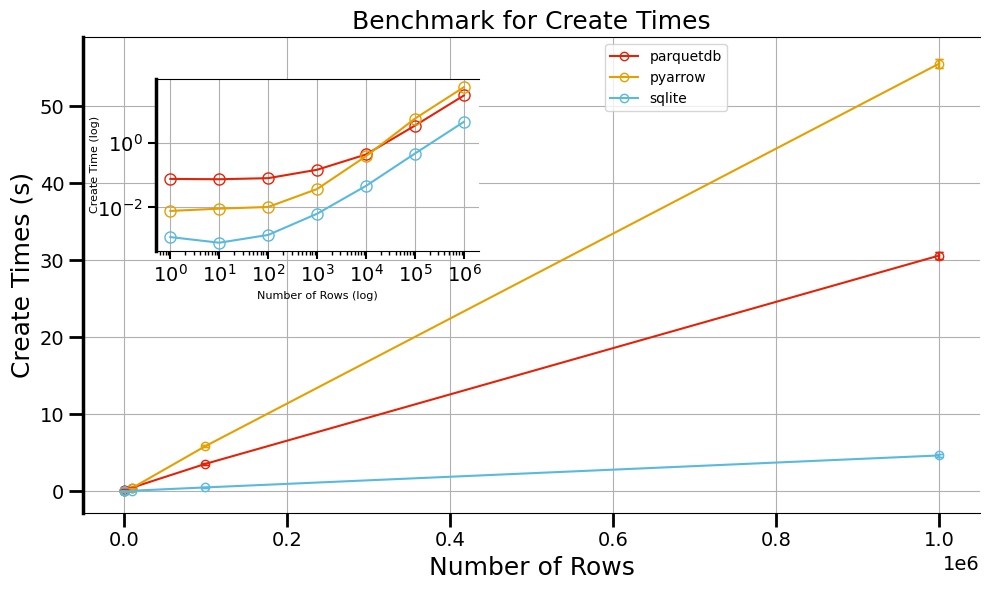

In [14]:
axes,ax_inset=plotting_experiments(benchmark_times=CREATE_TIMES)
axes.set_title("Benchmark for Create Times")
axes.set_ylabel("Create Times (s)")
ax_inset.set_ylabel("Create Time (log)", fontsize=8, labelpad=-2)
plt.tight_layout()
plt.show()

### Read Times

C:\Users\lllang\AppData\Local\Temp\ipykernel_33172\662491483.py:5: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


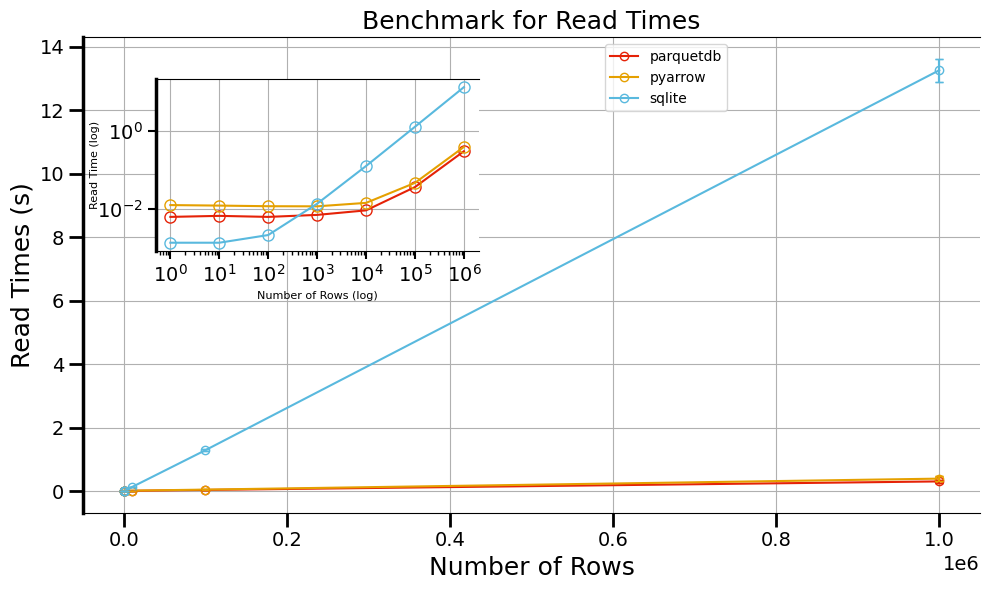

In [15]:
axes,ax_inset= plotting_experiments(benchmark_times=READ_TIMES)
axes.set_title("Benchmark for Read Times")
axes.set_ylabel("Read Times (s)")
ax_inset.set_ylabel("Read Time (log)", fontsize=8, labelpad=-2)
plt.tight_layout()
plt.show()

### Query Times

C:\Users\lllang\AppData\Local\Temp\ipykernel_33172\211292255.py:5: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


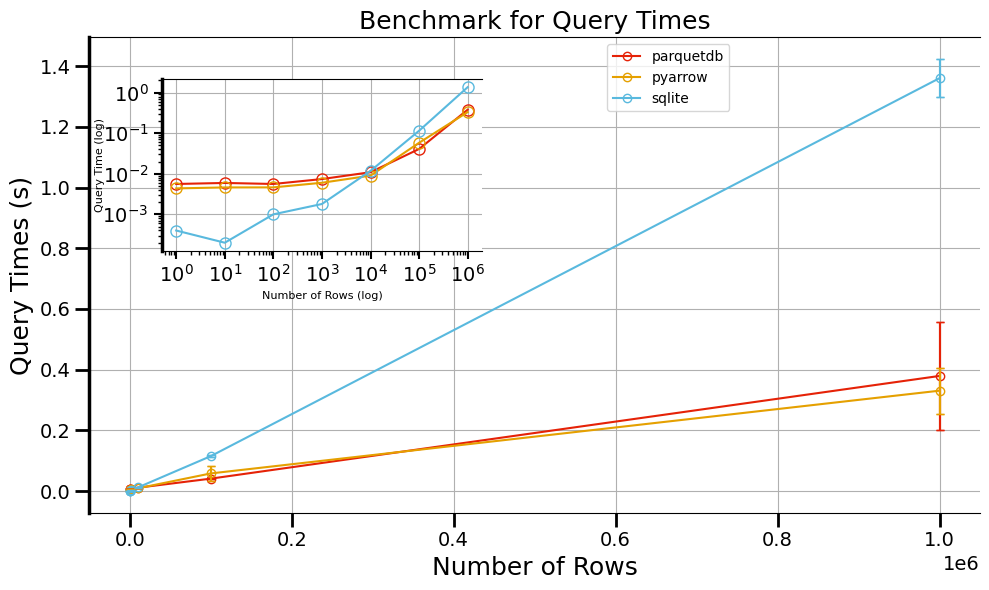

In [16]:
axes,ax_inset= plotting_experiments(benchmark_times=QUERY_TIMES)
axes.set_title("Benchmark for Query Times")
axes.set_ylabel("Query Times (s)")
ax_inset.set_ylabel("Query Time (log)", fontsize=8, labelpad=-2)
plt.tight_layout()
plt.show()

## Dicussion

1. **Create Times**  
   - **SQLite** scales best for raw inserts: its lightweight B‑tree writer in C outpaces both columnar solutions at every scale (≤ 1 M rows).  
   - **ParquetDB** is next.
   - **PyArrow** the worst perfromance: this can mainly be attributed to a difference in how the indices are generated.
   

2. **Read Times**  
   - **ParquetDB** & **PyArrow** are effectively identical: both return zero‑copy Arrow tables in ~0.1 s for 1 M rows, thanks to their native columnar layout and batch I/O.  
   - **SQLite** is ~40 × slower on full table scans, since it must fetch each row via a cursor and append into Python lists in a tight loop.

3. **Query Times**  
   - **ParquetDB** & **PyArrow** again match each other closely: filtering 1 M rows takes ~0.3–0.4 s, as Arrow applies vectorized predicates.  
   - **SQLite** requires ~1.8 s for the same filter, because every row check is a separate Python‑C transition and Python boolean append.

4. **Developer experience & boilerplate**  
   - A raw **PyArrow** workflow requires explicit directory management, manual ID generation, repeated calls to `pa.Table.from_pylist()`, `pq.write_table()`, and rebuilding the dataset for each operation—boilerplate that can be tedious to write, maintain, and debug.  
   - **ParquetDB** abstracts away all of that: you simply call `db.create(data)`, `db.read()`, or `db.read(filters=…)`. It manages file layouts, row‑group boundaries, indexing, and state under the hood, reducing cognitive load and speeding up development.

5. **Key takeaways**  
   - ParquetDB’s performance is dominated by the underlying Arrow I/O path—it inherits PyArrow’s blazing read/query speed, with only a small additional cost on table creation.  
   - For **write‑heavy** workloads up to ~1 M rows, SQLite still leads on raw insert throughput.  
   - For **analytics‑style** workloads (full scans or vectorized filters), the columnar engines (ParquetDB/PyArrow) deliver **an order of magnitude** better performance by avoiding Python‑level loops.  
   - For **developer productivity**, ParquetDB’s simple API can save hours of boilerplate code and eliminate error‑prone state management.
